# Shumovskaia Valentina, assignment #4.

In [120]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from math import cos
from math import sin
from math import sqrt
from scipy.optimize import least_squares
from scipy.optimize import minimize
import time
%matplotlib inline

### Task 1

The main idea: Denote $x_r$ and $x_b$ -- arrays from $x$-coordinates for robots and beacons positions. For every observation $i$ we know $x[i]$, indexes $k,m$ such that the following equation holds: $x_r[k] - x_b[m] = x[i]$. Thus, we can write the whole system $A[x_r,x_b] = x$ and solve it by lstsq. The same with $y-$s.

In [42]:
mat_contents = sio.loadmat('task1.mat')

In [43]:
beacons = mat_contents['beacons']
robots = mat_contents['robots']
dx = mat_contents['x']
dy = mat_contents['y']

In [44]:
N = beacons.shape[0] # number of observations
n_stops = len(np.unique(robots))
n_beacons = len(np.unique(beacons))

In [45]:
A = np.zeros((N, n_stops + n_beacons))
for i in range(N):
    stop = robots[i] - 1
    beacon = beacons[i] - 1
    A[i,stop] = -1
    A[i,n_stops + beacon] = 1

In [46]:
x = np.linalg.lstsq(A, dx)[0] #x[:n_stops] -- robot positions, x[n_stops:] -- beacon positions
y = np.linalg.lstsq(A, dy)[0]

In [47]:
x_r = x[:n_stops]
x_b = x[n_stops:]
y_r = y[:n_stops]
y_b = y[n_stops:]

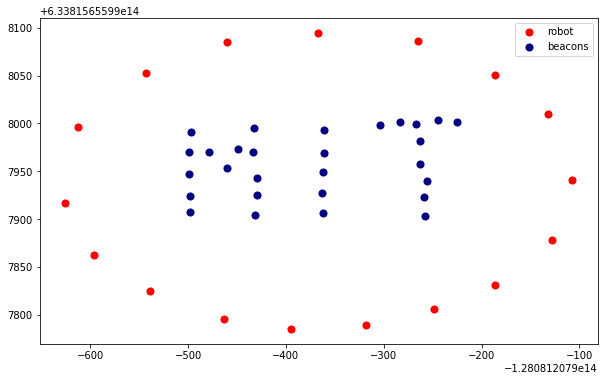

In [48]:
plt.figure(figsize=(10,6))
plt.scatter(x_b, y_b, c='red', label='robot', s=50)
plt.scatter(x_r, y_r, c='navy', label = 'beacons', s=50)
plt.legend()

If use explicit inversion of matrix:

In [49]:
A_1 = np.linalg.inv(A.T@A)

In [50]:
x_1 = A_1@A.T@dx
y_1 = A_1@A.T@dy

In [51]:
x_r_1 = x_1[:n_stops]
x_b_1 = x_1[n_stops:]
y_r_1 = y_1[:n_stops]
y_b_1 = y_1[n_stops:]

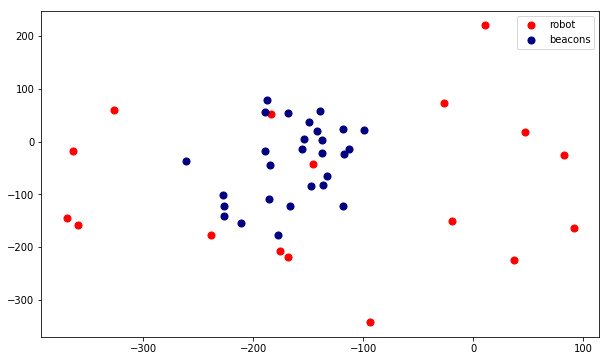

In [52]:
plt.figure(figsize=(10,6))
plt.scatter(x_b_1, y_b_1, c='red', label='robot', s=50)
plt.scatter(x_r_1, y_r_1, c='navy', label = 'beacons', s=50)
plt.legend()

### Task 2

Denote $x\_r$ and $x\_b$ -- arrays from $x$-coordinates for robots and beacons positions. Same with $y\_r, y\_b$. Also denote $a$ -- array from angles.

We want to minimize the following functions ($N$-- number of observations):
$$
i = 0,\dots,N-1,\\
f_i = x\_r_{robots[i]} + dx_i\cos({a_i}) + dy_i\sin({a_i}) - x\_b_{beacons[i]}\\
f_{N+i} = y\_r_{robots[i]} - dx_i\sin({a_i}) + dx_i\cos({a_i}) - y\_b_{beacons[i]}\\
$$

We want to use ```scipy.optimize.least_squares``` function, so let us define what is $w, f, J(f)$.

Let $f = (f_0,\dots,f_{2N-1})$, $w = (x\_r, y\_r, x\_b, y\_b, a)$.

Let's compute Jacobian, there are the following non-zero elements:
$$
i = 0,\dots,N-1,\\
\frac{\partial f_i}{\partial x\_r_{robots[i]}} = 1,\\
\frac{\partial f_{N+i}}{\partial y\_r_{robots[i]}} = 1,\\
\frac{\partial f_i}{\partial x\_r_{beacons[i]}} = -1,\\
\frac{\partial f_{N+i}}{\partial y\_r_{beacons[i]}} = -1,\\
\frac{\partial f_i}{\partial a_i} = -dx_i*sin(a_{stop})+dy_i*cos(a_{stop}),\\
\frac{\partial f_{N+i}}{\partial a_i} = -dx_i*sin(a_{stop}) + dy_i*cos(a_{stop}).\\
$$

In [53]:
mat_contents = sio.loadmat('task2.mat')

In [54]:
beacons = mat_contents['beacons']
robots = mat_contents['robots']
dx = mat_contents['x']
dy = mat_contents['y']

In [55]:
N = beacons.shape[0] # number of observations
n_stops = len(np.unique(robots))
n_beacons = len(np.unique(beacons))

In [3]:
def function(w, dx, dy):
    # w = (x_r, y_r, x_b, y_b, a)
    # N - number of observations
    # n_stops
    # n_beacons
    fun = np.zeros(2*N)
    for i in range(N):
        stop = robots[i] - 1
        beac = beacons[i] - 1
        x_r = w[:n_stops]
        y_r = w[n_stops:2*n_stops]
        x_b = w[2*n_stops:2*n_stops+n_beacons]
        y_b = w[2*n_stops+n_beacons:2*n_stops+2*n_beacons]
        a = w[2*n_stops+2*n_beacons:]
        fun[i] = x_r[stop] + (dx[i]*cos(a[stop]) + dy[i]*sin(a[stop])) - x_b[beac]
        j = N + i
        fun[j] = y_r[stop] + (-dx[i]*sin(a[stop]) + dy[i]*cos(a[stop])) - y_b[beac]
    return fun

def jacob_function(w, dx, dy):
    x_r = w[:n_stops]
    y_r = w[n_stops:2*n_stops]
    x_b = w[2*n_stops:2*n_stops+n_beacons]
    y_b = w[2*n_stops+n_beacons:2*n_stops+2*n_beacons]
    a = w[2*n_stops+2*n_beacons:]
    n_alphas = n_stops
    jac = np.zeros((2*N,2*n_stops + 2*n_beacons + n_alphas))
    for i in range(N):
        stop = robots[i] - 1
        beac = beacons[i] - 1
        jac[i,stop] = 1
        jac[N+i,n_stops+stop] = 1
        jac[i,2*n_stops+beac] = -1
        jac[N+i, 2*n_stops+n_beacons+beac] = -1
        jac[i, 2*n_stops+2*n_beacons+stop] = -dx[i]*sin(a[stop])+dy[i]*cos(a[stop])
        jac[N+i, 2*n_stops+2*n_beacons+stop] = -dx[i]*cos(a[stop])-dy[i]*sin(a[stop])
    return jac

In [57]:
# solve
w_0 = np.random.normal(size=[3*n_stops+2*n_beacons])
res = least_squares(function, w_0, jacob_function, args=(dx,dy), method='lm')

In [58]:
w = res.x
x_r = w[:n_stops]
y_r = w[n_stops:2*n_stops]
x_b = w[2*n_stops:2*n_stops+n_beacons]
y_b = w[2*n_stops+n_beacons:2*n_stops+2*n_beacons]
a = w[2*n_stops+2*n_beacons:]

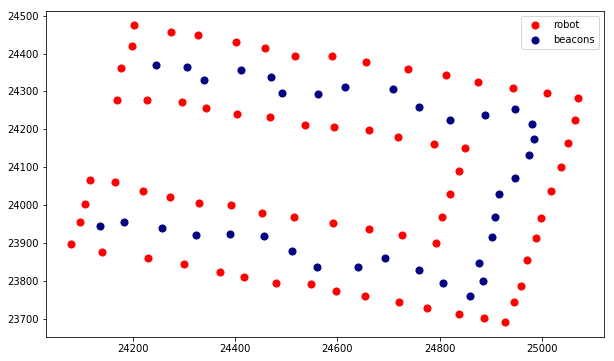

In [59]:
plt.figure(figsize=(10,6))
plt.scatter(x_b, y_b, c='red', label='robot', s=50)
plt.scatter(x_r, y_r, c='navy', label = 'beacons', s=50)
plt.legend()

In [60]:
print('robot orientations\n',a)

robot orientations
 [-0.0990131   0.18303888  0.95394675  0.74233895 -0.30841913  0.54651899
 -0.30935797 -0.19866623  0.01460282  0.46632822 -0.07100509  0.23364648
  0.34469109  0.06646976  0.7316161   0.86824277 -0.46130047 -0.18600456
  0.07146174  0.50162577 -0.28598811  0.27590108  0.78377047  0.56336696
  0.52907291 -0.12742373  0.87227274  0.32305248  0.10685639  0.23311044
  0.4899577  -0.42559243 -0.43749589 -0.10902639  0.56463686]


### Task 3

First, try to implement solution from the previous task.

In [11]:
mat_contents = sio.loadmat('task3.mat')

In [12]:
beacons = mat_contents['beacons']
robots = mat_contents['robots']
dx = mat_contents['x']
dy = mat_contents['y']

In [13]:
N = beacons.shape[0] # number of observations
n_stops = len(np.unique(robots))
n_beacons = len(np.unique(beacons))
N, n_stops, n_beacons

(460, 46, 60)

In [14]:
# solve
w_0 = np.random.normal(size=[3*n_stops+2*n_beacons])
res = least_squares(function, w_0, jacob_function, args=(dx,dy), method='lm')

In [15]:
w = res.x
x_r = w[:n_stops]
y_r = w[n_stops:2*n_stops]
x_b = w[2*n_stops:2*n_stops+n_beacons]
y_b = w[2*n_stops+n_beacons:2*n_stops+2*n_beacons]
a = w[2*n_stops+2*n_beacons:]

Solution like in the 2nd task does not work well


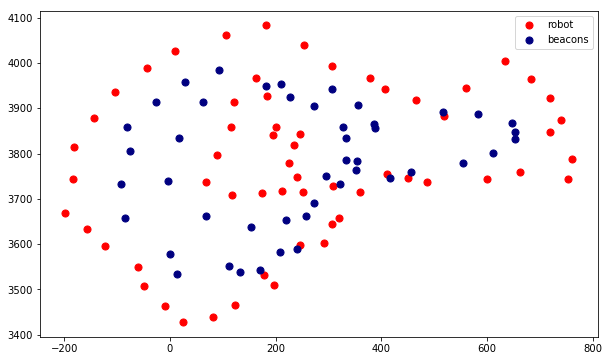

In [16]:
plt.figure(figsize=(10,6))
print('Solution like in the 2nd task does not work well')
plt.scatter(x_b, y_b, c='red', label='robot', s=50)
plt.scatter(x_r, y_r, c='navy', label = 'beacons', s=50)
plt.legend()

The result is not impressive. New robust solution:

Every $f_i$ replace by $h(f_i)$, where $h(u)$:
$$
h(u) =\begin{cases}
\frac{u^2}{2}, & \vert u \vert\leq M\\
M(\vert u \vert-\frac{M}{2}), & \vert u \vert>M
\end{cases}
$$

In [44]:
M = 1.0
def scalar_function(w, dx, dy):
    error = np.abs(function(w, dx, dy))
    error[error < M] = error[error < M]**2 / 2
    error[error >= M] = M*(error[error >= M] - M/2)
    return np.sum(error)

In [80]:
# initial solution w is the previous one
start = time.time()
res = minimize(fun=scalar_function, x0=w, args=(dx,dy), method='BFGS', options={'maxiter': 200})
end = time.time()
print('time elapsed {}'.format(end - start))

time elapsed 688.9626107215881


In [81]:
w = res.x
x_r = w[:n_stops]
y_r = w[n_stops:2*n_stops]
x_b = w[2*n_stops:2*n_stops+n_beacons]
y_b = w[2*n_stops+n_beacons:2*n_stops+2*n_beacons]
a = w[2*n_stops+2*n_beacons:]

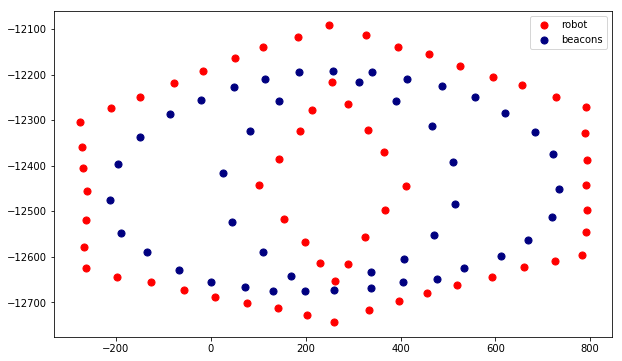

In [82]:
plt.figure(figsize=(10,6))
plt.scatter(x_b, y_b, c = 'red', label = 'robot', s = 50)
plt.scatter(x_r, y_r, c = 'navy', label = 'beacons', s = 50)
plt.legend()